In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms


import numpy as np
import matplotlib.pyplot as plt


import time

### Dataset Loading and Transformation

In [2]:


# Transforms defined for the train, validation, and test datasets
train_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor()])

val_transform = transforms.Compose([transforms.Resize((256,256)),
                                   transforms.ToTensor()])


In [3]:
dir = '../Label_Data_TrainTest/'
train_dir, val_dir, test_dir = dir+'train', dir+'val', dir+'test'
batch_size = 32
num_workers = 2

# Datasets extracted from their respective directories and some transformation applied to them
train_set = datasets.ImageFolder(train_dir, transform = train_transform)
val_set = datasets.ImageFolder(val_dir, transform = val_transform)


# Datasets loaded onto iterable object in form of batches 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=True, num_workers=num_workers)



### Loading the pretrained densenet161() model

In [4]:
from torchvision import models
classifier = models.densenet161(pretrained=True)


    
# Modify the last fully connected layer in the model
classifier.classifier = nn.Linear(in_features=2208, out_features=len(train_set.classes))

# Use GPU computation if available
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

device = torch.device('cuda')
# classifier.to(torch.device('cuda'))

# Train on multiple GPU cores if possible
if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  classifier = nn.DataParallel(classifier)

classifier.to(device)

Using 2 GPUs!


DataParallel(
  (module): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentu

### Training the Network

In [5]:
learning_rate = 1.0e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)


In [6]:

iterations = 4000
loss_train_list = list()
train_accuracy_list = list()

start = time.time()

for i in range(1,iterations+1):
    classifier.train()
    
    images_train, labels_train = iter(train_loader).next()
    images_train, labels_train = images_train.to(device), labels_train.to(device)
    
    optimizer.zero_grad()
    
    output_train = classifier.forward(images_train)
    loss_train = criterion(output_train, labels_train)
    prediction_train = output_train.max(dim=1)[1]

    counter_train = (labels_train == prediction_train).sum().item()
    loss_train_list.append(loss_train)
    train_accuracy_list.append(counter_train/len(output_train))
   
    if i%10 == 0:
        print("Iteration number: {}/{}".format(i, iterations))
        print('Training Accuracy: {:.3f}%'.format(counter_train/len(output_train) * 100))
        time_taken = time.time() - start
        print('Time elapsed: {:.0f}h {:.0f}m {:.0f}s'.format(time_taken//3600, (time_taken%3600)//60, (time_taken%3600)%60))
        print('='*70)
    loss_train.backward()
    optimizer.step()
    

print('Training Finished!')
print('Time elapsed: {:.0f}h {:.0f}m {:.0f}s'.format(time_taken//3600, (time_taken%3600)//60, (time_taken%3600)%60))


Iteration number: 10/4000
Training Accuracy: 12.500%
Time elapsed: 0h 0m 19s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 20/4000
Training Accuracy: 18.750%
Time elapsed: 0h 0m 36s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 30/4000
Training Accuracy: 28.125%
Time elapsed: 0h 0m 55s
Iteration number: 40/4000
Training Accuracy: 34.375%
Time elapsed: 0h 1m 12s
Iteration number: 50/4000
Training Accuracy: 25.000%
Time elapsed: 0h 1m 30s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 60/4000
Training Accuracy: 46.875%
Time elapsed: 0h 1m 48s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 70/4000
Training Accuracy: 43.750%
Time elapsed: 0h 2m 5s
Iteration number: 80/4000
Training Accuracy: 62.500%
Time elapsed: 0h 2m 22s
Iteration number: 90/4000
Training Accuracy: 53.125%
Time elapsed: 0h 2m 40s
Iteration number: 100/4000
Training Accuracy: 53.125%
Time elapsed: 0h 2m 57s
Iteration number: 110/4000
Training Accuracy: 62.500%
Time elapsed: 0h 3m 15s
Iteration number: 120/4000
Training Accuracy: 75.000%
Time elapsed: 0h 3m 32s
Iteration number: 130/4000
Training Accuracy: 75.000%
Time elapsed: 0h 3m 50s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 140/4000
Training Accuracy: 87.500%
Time elapsed: 0h 4m 8s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 150/4000
Training Accuracy: 71.875%
Time elapsed: 0h 4m 25s
Iteration number: 160/4000
Training Accuracy: 81.250%
Time elapsed: 0h 4m 44s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 170/4000
Training Accuracy: 84.375%
Time elapsed: 0h 5m 1s
Iteration number: 180/4000
Training Accuracy: 90.625%
Time elapsed: 0h 5m 19s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 190/4000
Training Accuracy: 75.000%
Time elapsed: 0h 5m 36s
Iteration number: 200/4000
Training Accuracy: 84.375%
Time elapsed: 0h 5m 54s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 210/4000
Training Accuracy: 96.875%
Time elapsed: 0h 6m 11s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 220/4000
Training Accuracy: 87.500%
Time elapsed: 0h 6m 29s
Iteration number: 230/4000
Training Accuracy: 78.125%
Time elapsed: 0h 6m 47s
Iteration number: 240/4000
Training Accuracy: 90.625%
Time elapsed: 0h 7m 5s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 250/4000
Training Accuracy: 96.875%
Time elapsed: 0h 7m 23s
Iteration number: 260/4000
Training Accuracy: 84.375%
Time elapsed: 0h 7m 41s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 270/4000
Training Accuracy: 87.500%
Time elapsed: 0h 7m 60s
Iteration number: 280/4000
Training Accuracy: 84.375%
Time elapsed: 0h 8m 18s
Iteration number: 290/4000
Training Accuracy: 93.750%
Time elapsed: 0h 8m 37s
Iteration number: 300/4000
Training Accuracy: 93.750%
Time elapsed: 0h 8m 54s
Iteration number: 310/4000
Training Accuracy: 93.750%
Time elapsed: 0h 9m 12s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 320/4000
Training Accuracy: 96.875%
Time elapsed: 0h 9m 31s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 330/4000
Training Accuracy: 87.500%
Time elapsed: 0h 9m 49s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 340/4000
Training Accuracy: 100.000%
Time elapsed: 0h 10m 7s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 350/4000
Training Accuracy: 81.250%
Time elapsed: 0h 10m 25s
Iteration number: 360/4000
Training Accuracy: 84.375%
Time elapsed: 0h 10m 43s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 370/4000
Training Accuracy: 93.750%
Time elapsed: 0h 11m 1s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 380/4000
Training Accuracy: 93.750%
Time elapsed: 0h 11m 19s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 390/4000
Training Accuracy: 100.000%
Time elapsed: 0h 11m 38s
Iteration number: 400/4000
Training Accuracy: 93.750%
Time elapsed: 0h 11m 56s
Iteration number: 410/4000
Training Accuracy: 96.875%
Time elapsed: 0h 12m 16s
Iteration number: 420/4000
Training Accuracy: 93.750%
Time elapsed: 0h 12m 34s
Iteration number: 430/4000
Training Accuracy: 93.750%
Time elapsed: 0h 12m 54s
Iteration number: 440/4000
Training Accuracy: 90.625%
Time elapsed: 0h 13m 13s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 450/4000
Training Accuracy: 100.000%
Time elapsed: 0h 13m 31s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 460/4000
Training Accuracy: 96.875%
Time elapsed: 0h 13m 49s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 470/4000
Training Accuracy: 96.875%
Time elapsed: 0h 14m 6s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 480/4000
Training Accuracy: 93.750%
Time elapsed: 0h 14m 25s
Iteration number: 490/4000
Training Accuracy: 96.875%
Time elapsed: 0h 14m 44s
Iteration number: 500/4000
Training Accuracy: 90.625%
Time elapsed: 0h 15m 3s
Iteration number: 510/4000
Training Accuracy: 96.875%
Time elapsed: 0h 15m 20s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 520/4000
Training Accuracy: 93.750%
Time elapsed: 0h 15m 38s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 530/4000
Training Accuracy: 96.875%
Time elapsed: 0h 15m 57s
Iteration number: 540/4000
Training Accuracy: 93.750%
Time elapsed: 0h 16m 15s
Iteration number: 550/4000
Training Accuracy: 96.875%
Time elapsed: 0h 16m 33s
Iteration number: 560/4000
Training Accuracy: 93.750%
Time elapsed: 0h 16m 51s
Iteration number: 570/4000
Training Accuracy: 93.750%
Time elapsed: 0h 17m 9s
Iteration number: 580/4000
Training Accuracy: 100.000%
Time elapsed: 0h 17m 26s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 590/4000
Training Accuracy: 96.875%
Time elapsed: 0h 17m 44s
Iteration number: 600/4000
Training Accuracy: 90.625%
Time elapsed: 0h 18m 3s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 610/4000
Training Accuracy: 96.875%
Time elapsed: 0h 18m 20s
Iteration number: 620/4000
Training Accuracy: 96.875%
Time elapsed: 0h 18m 38s
Iteration number: 630/4000
Training Accuracy: 100.000%
Time elapsed: 0h 18m 56s
Iteration number: 640/4000
Training Accuracy: 100.000%
Time elapsed: 0h 19m 14s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 650/4000
Training Accuracy: 100.000%
Time elapsed: 0h 19m 31s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 660/4000
Training Accuracy: 96.875%
Time elapsed: 0h 19m 48s
Iteration number: 670/4000
Training Accuracy: 96.875%
Time elapsed: 0h 20m 6s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 680/4000
Training Accuracy: 100.000%
Time elapsed: 0h 20m 25s
Iteration number: 690/4000
Training Accuracy: 100.000%
Time elapsed: 0h 20m 42s
Iteration number: 700/4000
Training Accuracy: 96.875%
Time elapsed: 0h 20m 60s
Iteration number: 710/4000
Training Accuracy: 100.000%
Time elapsed: 0h 21m 17s
Iteration number: 720/4000
Training Accuracy: 96.875%
Time elapsed: 0h 21m 36s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 730/4000
Training Accuracy: 93.750%
Time elapsed: 0h 21m 54s
Iteration number: 740/4000
Training Accuracy: 100.000%
Time elapsed: 0h 22m 12s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 750/4000
Training Accuracy: 96.875%
Time elapsed: 0h 22m 30s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 760/4000
Training Accuracy: 100.000%
Time elapsed: 0h 22m 49s
Iteration number: 770/4000
Training Accuracy: 100.000%
Time elapsed: 0h 23m 8s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 780/4000
Training Accuracy: 96.875%
Time elapsed: 0h 23m 25s
Iteration number: 790/4000
Training Accuracy: 100.000%
Time elapsed: 0h 23m 44s
Iteration number: 800/4000
Training Accuracy: 100.000%
Time elapsed: 0h 24m 1s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 810/4000
Training Accuracy: 100.000%
Time elapsed: 0h 24m 20s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 820/4000
Training Accuracy: 100.000%
Time elapsed: 0h 24m 38s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 830/4000
Training Accuracy: 100.000%
Time elapsed: 0h 24m 56s
Iteration number: 840/4000
Training Accuracy: 100.000%
Time elapsed: 0h 25m 15s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 850/4000
Training Accuracy: 100.000%
Time elapsed: 0h 25m 33s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 860/4000
Training Accuracy: 100.000%
Time elapsed: 0h 25m 49s
Iteration number: 870/4000
Training Accuracy: 100.000%
Time elapsed: 0h 26m 8s
Iteration number: 880/4000
Training Accuracy: 100.000%
Time elapsed: 0h 26m 26s
Iteration number: 890/4000
Training Accuracy: 100.000%
Time elapsed: 0h 26m 44s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 900/4000
Training Accuracy: 100.000%
Time elapsed: 0h 27m 1s
Iteration number: 910/4000
Training Accuracy: 100.000%
Time elapsed: 0h 27m 20s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 920/4000
Training Accuracy: 96.875%
Time elapsed: 0h 27m 38s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 930/4000
Training Accuracy: 100.000%
Time elapsed: 0h 27m 56s
Iteration number: 940/4000
Training Accuracy: 100.000%
Time elapsed: 0h 28m 16s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 950/4000
Training Accuracy: 100.000%
Time elapsed: 0h 28m 34s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 960/4000
Training Accuracy: 100.000%
Time elapsed: 0h 28m 52s
Iteration number: 970/4000
Training Accuracy: 100.000%
Time elapsed: 0h 29m 10s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 980/4000
Training Accuracy: 100.000%
Time elapsed: 0h 29m 29s
Iteration number: 990/4000
Training Accuracy: 100.000%
Time elapsed: 0h 29m 48s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1000/4000
Training Accuracy: 100.000%
Time elapsed: 0h 30m 6s
Iteration number: 1010/4000
Training Accuracy: 100.000%
Time elapsed: 0h 30m 24s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1020/4000
Training Accuracy: 100.000%
Time elapsed: 0h 30m 42s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1030/4000
Training Accuracy: 100.000%
Time elapsed: 0h 30m 60s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1040/4000
Training Accuracy: 100.000%
Time elapsed: 0h 31m 18s
Iteration number: 1050/4000
Training Accuracy: 100.000%
Time elapsed: 0h 31m 36s
Iteration number: 1060/4000
Training Accuracy: 100.000%
Time elapsed: 0h 31m 54s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1070/4000
Training Accuracy: 100.000%
Time elapsed: 0h 32m 12s
Iteration number: 1080/4000
Training Accuracy: 100.000%
Time elapsed: 0h 32m 31s
Iteration number: 1090/4000
Training Accuracy: 100.000%
Time elapsed: 0h 32m 50s
Iteration number: 1100/4000
Training Accuracy: 96.875%
Time elapsed: 0h 33m 8s
Iteration number: 1110/4000
Training Accuracy: 100.000%
Time elapsed: 0h 33m 26s
Iteration number: 1120/4000
Training Accuracy: 96.875%
Time elapsed: 0h 33m 44s
Iteration number: 1130/4000
Training Accuracy: 100.000%
Time elapsed: 0h 34m 3s
Iteration number: 1140/4000
Training Accuracy: 100.000%
Time elapsed: 0h 34m 22s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1150/4000
Training Accuracy: 93.750%
Time elapsed: 0h 34m 39s
Iteration number: 1160/4000
Training Accuracy: 100.000%
Time elapsed: 0h 34m 58s
Iteration number: 1170/4000
Training Accuracy: 100.000%
Time elapsed: 0h 35m 17s
Iteration number: 1180/4000
Training Accuracy: 100.000%
Time elapsed: 0h 35m 35s
Iteration number: 1190/4000
Training Accuracy: 100.000%
Time elapsed: 0h 35m 55s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1200/4000
Training Accuracy: 100.000%
Time elapsed: 0h 36m 14s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1210/4000
Training Accuracy: 100.000%
Time elapsed: 0h 36m 33s
Iteration number: 1220/4000
Training Accuracy: 96.875%
Time elapsed: 0h 36m 51s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1230/4000
Training Accuracy: 100.000%
Time elapsed: 0h 37m 9s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1240/4000
Training Accuracy: 96.875%
Time elapsed: 0h 37m 27s
Iteration number: 1250/4000
Training Accuracy: 100.000%
Time elapsed: 0h 37m 46s
Iteration number: 1260/4000
Training Accuracy: 100.000%
Time elapsed: 0h 38m 3s
Iteration number: 1270/4000
Training Accuracy: 96.875%
Time elapsed: 0h 38m 20s
Iteration number: 1280/4000
Training Accuracy: 100.000%
Time elapsed: 0h 38m 38s
Iteration number: 1290/4000
Training Accuracy: 100.000%
Time elapsed: 0h 38m 56s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1300/4000
Training Accuracy: 100.000%
Time elapsed: 0h 39m 14s
Iteration number: 1310/4000
Training Accuracy: 100.000%
Time elapsed: 0h 39m 32s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1320/4000
Training Accuracy: 100.000%
Time elapsed: 0h 39m 49s
Iteration number: 1330/4000
Training Accuracy: 100.000%
Time elapsed: 0h 40m 8s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1340/4000
Training Accuracy: 100.000%
Time elapsed: 0h 40m 25s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1350/4000
Training Accuracy: 100.000%
Time elapsed: 0h 40m 43s
Iteration number: 1360/4000
Training Accuracy: 96.875%
Time elapsed: 0h 41m 0s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1370/4000
Training Accuracy: 100.000%
Time elapsed: 0h 41m 19s
Iteration number: 1380/4000
Training Accuracy: 100.000%
Time elapsed: 0h 41m 37s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1390/4000
Training Accuracy: 100.000%
Time elapsed: 0h 41m 55s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1400/4000
Training Accuracy: 100.000%
Time elapsed: 0h 42m 14s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1410/4000
Training Accuracy: 93.750%
Time elapsed: 0h 42m 32s
Iteration number: 1420/4000
Training Accuracy: 100.000%
Time elapsed: 0h 42m 51s
Iteration number: 1430/4000
Training Accuracy: 100.000%
Time elapsed: 0h 43m 10s
Iteration number: 1440/4000
Training Accuracy: 100.000%
Time elapsed: 0h 43m 27s
Iteration number: 1450/4000
Training Accuracy: 100.000%
Time elapsed: 0h 43m 45s
Iteration number: 1460/4000
Training Accuracy: 100.000%
Time elapsed: 0h 44m 4s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1470/4000
Training Accuracy: 100.000%
Time elapsed: 0h 44m 22s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1480/4000
Training Accuracy: 100.000%
Time elapsed: 0h 44m 41s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1490/4000
Training Accuracy: 100.000%
Time elapsed: 0h 44m 59s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1500/4000
Training Accuracy: 100.000%
Time elapsed: 0h 45m 17s
Iteration number: 1510/4000
Training Accuracy: 100.000%
Time elapsed: 0h 45m 35s
Iteration number: 1520/4000
Training Accuracy: 96.875%
Time elapsed: 0h 45m 53s
Iteration number: 1530/4000
Training Accuracy: 100.000%
Time elapsed: 0h 46m 11s
Iteration number: 1540/4000
Training Accuracy: 100.000%
Time elapsed: 0h 46m 29s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1550/4000
Training Accuracy: 100.000%
Time elapsed: 0h 46m 47s
Iteration number: 1560/4000
Training Accuracy: 100.000%
Time elapsed: 0h 47m 5s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1570/4000
Training Accuracy: 100.000%
Time elapsed: 0h 47m 24s
Iteration number: 1580/4000
Training Accuracy: 100.000%
Time elapsed: 0h 47m 42s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1590/4000
Training Accuracy: 100.000%
Time elapsed: 0h 48m 1s
Iteration number: 1600/4000
Training Accuracy: 100.000%
Time elapsed: 0h 48m 20s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1610/4000
Training Accuracy: 100.000%
Time elapsed: 0h 48m 38s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1620/4000
Training Accuracy: 100.000%
Time elapsed: 0h 48m 57s
Iteration number: 1630/4000
Training Accuracy: 100.000%
Time elapsed: 0h 49m 16s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1640/4000
Training Accuracy: 100.000%
Time elapsed: 0h 49m 34s
Iteration number: 1650/4000
Training Accuracy: 100.000%
Time elapsed: 0h 49m 54s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1660/4000
Training Accuracy: 100.000%
Time elapsed: 0h 50m 13s
Iteration number: 1670/4000
Training Accuracy: 100.000%
Time elapsed: 0h 50m 31s
Iteration number: 1680/4000
Training Accuracy: 100.000%
Time elapsed: 0h 50m 49s
Iteration number: 1690/4000
Training Accuracy: 100.000%
Time elapsed: 0h 51m 7s
Iteration number: 1700/4000
Training Accuracy: 100.000%
Time elapsed: 0h 51m 26s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1710/4000
Training Accuracy: 100.000%
Time elapsed: 0h 51m 44s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1720/4000
Training Accuracy: 100.000%
Time elapsed: 0h 52m 2s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1730/4000
Training Accuracy: 100.000%
Time elapsed: 0h 52m 20s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1740/4000
Training Accuracy: 100.000%
Time elapsed: 0h 52m 39s
Iteration number: 1750/4000
Training Accuracy: 100.000%
Time elapsed: 0h 52m 59s
Iteration number: 1760/4000
Training Accuracy: 100.000%
Time elapsed: 0h 53m 18s
Iteration number: 1770/4000
Training Accuracy: 100.000%
Time elapsed: 0h 53m 36s
Iteration number: 1780/4000
Training Accuracy: 100.000%
Time elapsed: 0h 53m 54s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1790/4000
Training Accuracy: 100.000%
Time elapsed: 0h 54m 13s
Iteration number: 1800/4000
Training Accuracy: 100.000%
Time elapsed: 0h 54m 32s
Iteration number: 1810/4000
Training Accuracy: 100.000%
Time elapsed: 0h 54m 50s
Iteration number: 1820/4000
Training Accuracy: 100.000%
Time elapsed: 0h 55m 8s
Iteration number: 1830/4000
Training Accuracy: 100.000%
Time elapsed: 0h 55m 26s
Iteration number: 1840/4000
Training Accuracy: 100.000%
Time elapsed: 0h 55m 44s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1850/4000
Training Accuracy: 100.000%
Time elapsed: 0h 56m 2s
Iteration number: 1860/4000
Training Accuracy: 100.000%
Time elapsed: 0h 56m 21s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1870/4000
Training Accuracy: 100.000%
Time elapsed: 0h 56m 39s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1880/4000
Training Accuracy: 100.000%
Time elapsed: 0h 56m 57s
Iteration number: 1890/4000
Training Accuracy: 100.000%
Time elapsed: 0h 57m 15s
Iteration number: 1900/4000
Training Accuracy: 100.000%
Time elapsed: 0h 57m 34s
Iteration number: 1910/4000
Training Accuracy: 100.000%
Time elapsed: 0h 57m 53s
Iteration number: 1920/4000
Training Accuracy: 100.000%
Time elapsed: 0h 58m 12s
Iteration number: 1930/4000
Training Accuracy: 100.000%
Time elapsed: 0h 58m 31s
Iteration number: 1940/4000
Training Accuracy: 100.000%
Time elapsed: 0h 58m 49s
Iteration number: 1950/4000
Training Accuracy: 100.000%
Time elapsed: 0h 59m 6s
Iteration number: 1960/4000
Training Accuracy: 100.000%
Time elapsed: 0h 59m 24s
Iteration number: 1970/4000
Training Accuracy: 100.000%
Time elapsed: 0h 59m 42s
Iteration number: 1980/4000
Training Accuracy: 96.875%
Time elapsed: 1h 0m 1s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 1990/4000
Training Accuracy: 100.000%
Time elapsed: 1h 0m 20s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2000/4000
Training Accuracy: 100.000%
Time elapsed: 1h 0m 38s
Iteration number: 2010/4000
Training Accuracy: 100.000%
Time elapsed: 1h 0m 56s
Iteration number: 2020/4000
Training Accuracy: 100.000%
Time elapsed: 1h 1m 15s
Iteration number: 2030/4000
Training Accuracy: 100.000%
Time elapsed: 1h 1m 33s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2040/4000
Training Accuracy: 100.000%
Time elapsed: 1h 1m 51s
Iteration number: 2050/4000
Training Accuracy: 100.000%
Time elapsed: 1h 2m 9s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2060/4000
Training Accuracy: 100.000%
Time elapsed: 1h 2m 27s
Iteration number: 2070/4000
Training Accuracy: 100.000%
Time elapsed: 1h 2m 47s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2080/4000
Training Accuracy: 100.000%
Time elapsed: 1h 3m 5s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2090/4000
Training Accuracy: 100.000%
Time elapsed: 1h 3m 24s
Iteration number: 2100/4000
Training Accuracy: 96.875%
Time elapsed: 1h 3m 43s
Iteration number: 2110/4000
Training Accuracy: 100.000%
Time elapsed: 1h 4m 1s
Iteration number: 2120/4000
Training Accuracy: 100.000%
Time elapsed: 1h 4m 19s
Iteration number: 2130/4000
Training Accuracy: 100.000%
Time elapsed: 1h 4m 37s
Iteration number: 2140/4000
Training Accuracy: 100.000%
Time elapsed: 1h 4m 55s
Iteration number: 2150/4000
Training Accuracy: 100.000%
Time elapsed: 1h 5m 13s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2160/4000
Training Accuracy: 100.000%
Time elapsed: 1h 5m 31s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2170/4000
Training Accuracy: 100.000%
Time elapsed: 1h 5m 50s
Iteration number: 2180/4000
Training Accuracy: 100.000%
Time elapsed: 1h 6m 9s
Iteration number: 2190/4000
Training Accuracy: 100.000%
Time elapsed: 1h 6m 26s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2200/4000
Training Accuracy: 100.000%
Time elapsed: 1h 6m 45s
Iteration number: 2210/4000
Training Accuracy: 100.000%
Time elapsed: 1h 7m 3s
Iteration number: 2220/4000
Training Accuracy: 100.000%
Time elapsed: 1h 7m 22s
Iteration number: 2230/4000
Training Accuracy: 100.000%
Time elapsed: 1h 7m 41s
Iteration number: 2240/4000
Training Accuracy: 100.000%
Time elapsed: 1h 7m 59s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2250/4000
Training Accuracy: 100.000%
Time elapsed: 1h 8m 18s
Iteration number: 2260/4000
Training Accuracy: 100.000%
Time elapsed: 1h 8m 35s
Iteration number: 2270/4000
Training Accuracy: 100.000%
Time elapsed: 1h 8m 53s
Iteration number: 2280/4000
Training Accuracy: 100.000%
Time elapsed: 1h 9m 12s
Iteration number: 2290/4000
Training Accuracy: 100.000%
Time elapsed: 1h 9m 31s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2300/4000
Training Accuracy: 100.000%
Time elapsed: 1h 9m 49s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2310/4000
Training Accuracy: 100.000%
Time elapsed: 1h 10m 9s
Iteration number: 2320/4000
Training Accuracy: 100.000%
Time elapsed: 1h 10m 28s
Iteration number: 2330/4000
Training Accuracy: 100.000%
Time elapsed: 1h 10m 47s
Iteration number: 2340/4000
Training Accuracy: 100.000%
Time elapsed: 1h 11m 5s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2350/4000
Training Accuracy: 100.000%
Time elapsed: 1h 11m 24s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2360/4000
Training Accuracy: 100.000%
Time elapsed: 1h 11m 44s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2370/4000
Training Accuracy: 100.000%
Time elapsed: 1h 12m 3s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2380/4000
Training Accuracy: 100.000%
Time elapsed: 1h 12m 21s
Iteration number: 2390/4000
Training Accuracy: 100.000%
Time elapsed: 1h 12m 39s
Iteration number: 2400/4000
Training Accuracy: 100.000%
Time elapsed: 1h 12m 59s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2410/4000
Training Accuracy: 100.000%
Time elapsed: 1h 13m 18s
Iteration number: 2420/4000
Training Accuracy: 100.000%
Time elapsed: 1h 13m 36s
Iteration number: 2430/4000
Training Accuracy: 100.000%
Time elapsed: 1h 13m 55s
Iteration number: 2440/4000
Training Accuracy: 100.000%
Time elapsed: 1h 14m 12s
Iteration number: 2450/4000
Training Accuracy: 100.000%
Time elapsed: 1h 14m 31s
Iteration number: 2460/4000
Training Accuracy: 100.000%
Time elapsed: 1h 14m 51s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2470/4000
Training Accuracy: 96.875%
Time elapsed: 1h 15m 10s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2480/4000
Training Accuracy: 100.000%
Time elapsed: 1h 15m 29s
Iteration number: 2490/4000
Training Accuracy: 100.000%
Time elapsed: 1h 15m 47s
Iteration number: 2500/4000
Training Accuracy: 100.000%
Time elapsed: 1h 16m 6s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2510/4000
Training Accuracy: 100.000%
Time elapsed: 1h 16m 25s
Iteration number: 2520/4000
Training Accuracy: 100.000%
Time elapsed: 1h 16m 44s
Iteration number: 2530/4000
Training Accuracy: 100.000%
Time elapsed: 1h 17m 3s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2540/4000
Training Accuracy: 100.000%
Time elapsed: 1h 17m 21s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2550/4000
Training Accuracy: 100.000%
Time elapsed: 1h 17m 40s
Iteration number: 2560/4000
Training Accuracy: 100.000%
Time elapsed: 1h 17m 59s
Iteration number: 2570/4000
Training Accuracy: 100.000%
Time elapsed: 1h 18m 18s
Iteration number: 2580/4000
Training Accuracy: 100.000%
Time elapsed: 1h 18m 36s
Iteration number: 2590/4000
Training Accuracy: 100.000%
Time elapsed: 1h 18m 54s
Iteration number: 2600/4000
Training Accuracy: 100.000%
Time elapsed: 1h 19m 13s
Iteration number: 2610/4000
Training Accuracy: 100.000%
Time elapsed: 1h 19m 31s
Iteration number: 2620/4000
Training Accuracy: 100.000%
Time elapsed: 1h 19m 49s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2630/4000
Training Accuracy: 100.000%
Time elapsed: 1h 20m 8s
Iteration number: 2640/4000
Training Accuracy: 100.000%
Time elapsed: 1h 20m 26s
Iteration number: 2650/4000
Training Accuracy: 100.000%
Time elapsed: 1h 20m 45s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2660/4000
Training Accuracy: 100.000%
Time elapsed: 1h 21m 4s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2670/4000
Training Accuracy: 100.000%
Time elapsed: 1h 21m 23s
Iteration number: 2680/4000
Training Accuracy: 100.000%
Time elapsed: 1h 21m 41s
Iteration number: 2690/4000
Training Accuracy: 100.000%
Time elapsed: 1h 21m 58s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2700/4000
Training Accuracy: 100.000%
Time elapsed: 1h 22m 16s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2710/4000
Training Accuracy: 100.000%
Time elapsed: 1h 22m 34s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2720/4000
Training Accuracy: 100.000%
Time elapsed: 1h 22m 53s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2730/4000
Training Accuracy: 100.000%
Time elapsed: 1h 23m 12s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2740/4000
Training Accuracy: 100.000%
Time elapsed: 1h 23m 32s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2750/4000
Training Accuracy: 100.000%
Time elapsed: 1h 23m 51s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2760/4000
Training Accuracy: 100.000%
Time elapsed: 1h 24m 11s
Iteration number: 2770/4000
Training Accuracy: 100.000%
Time elapsed: 1h 24m 31s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2780/4000
Training Accuracy: 100.000%
Time elapsed: 1h 24m 50s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2790/4000
Training Accuracy: 100.000%
Time elapsed: 1h 25m 9s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2800/4000
Training Accuracy: 100.000%
Time elapsed: 1h 25m 28s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2810/4000
Training Accuracy: 100.000%
Time elapsed: 1h 25m 47s
Iteration number: 2820/4000
Training Accuracy: 100.000%
Time elapsed: 1h 26m 6s
Iteration number: 2830/4000
Training Accuracy: 100.000%
Time elapsed: 1h 26m 26s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2840/4000
Training Accuracy: 100.000%
Time elapsed: 1h 26m 45s
Iteration number: 2850/4000
Training Accuracy: 100.000%
Time elapsed: 1h 27m 4s
Iteration number: 2860/4000
Training Accuracy: 100.000%
Time elapsed: 1h 27m 23s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2870/4000
Training Accuracy: 100.000%
Time elapsed: 1h 27m 42s
Iteration number: 2880/4000
Training Accuracy: 100.000%
Time elapsed: 1h 27m 60s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2890/4000
Training Accuracy: 100.000%
Time elapsed: 1h 28m 18s
Iteration number: 2900/4000
Training Accuracy: 100.000%
Time elapsed: 1h 28m 37s
Iteration number: 2910/4000
Training Accuracy: 100.000%
Time elapsed: 1h 28m 56s
Iteration number: 2920/4000
Training Accuracy: 100.000%
Time elapsed: 1h 29m 14s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2930/4000
Training Accuracy: 96.875%
Time elapsed: 1h 29m 34s
Iteration number: 2940/4000
Training Accuracy: 100.000%
Time elapsed: 1h 29m 53s
Iteration number: 2950/4000
Training Accuracy: 100.000%
Time elapsed: 1h 30m 11s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2960/4000
Training Accuracy: 100.000%
Time elapsed: 1h 30m 30s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2970/4000
Training Accuracy: 100.000%
Time elapsed: 1h 30m 49s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2980/4000
Training Accuracy: 100.000%
Time elapsed: 1h 31m 9s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 2990/4000
Training Accuracy: 100.000%
Time elapsed: 1h 31m 28s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3000/4000
Training Accuracy: 100.000%
Time elapsed: 1h 31m 48s
Iteration number: 3010/4000
Training Accuracy: 100.000%
Time elapsed: 1h 32m 7s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3020/4000
Training Accuracy: 100.000%
Time elapsed: 1h 32m 25s
Iteration number: 3030/4000
Training Accuracy: 100.000%
Time elapsed: 1h 32m 44s
Iteration number: 3040/4000
Training Accuracy: 100.000%
Time elapsed: 1h 33m 3s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3050/4000
Training Accuracy: 100.000%
Time elapsed: 1h 33m 22s
Iteration number: 3060/4000
Training Accuracy: 100.000%
Time elapsed: 1h 33m 42s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3070/4000
Training Accuracy: 100.000%
Time elapsed: 1h 34m 1s
Iteration number: 3080/4000
Training Accuracy: 100.000%
Time elapsed: 1h 34m 20s
Iteration number: 3090/4000
Training Accuracy: 100.000%
Time elapsed: 1h 34m 38s
Iteration number: 3100/4000
Training Accuracy: 100.000%
Time elapsed: 1h 34m 58s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3110/4000
Training Accuracy: 100.000%
Time elapsed: 1h 35m 18s
Iteration number: 3120/4000
Training Accuracy: 96.875%
Time elapsed: 1h 35m 37s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3130/4000
Training Accuracy: 100.000%
Time elapsed: 1h 35m 56s
Iteration number: 3140/4000
Training Accuracy: 100.000%
Time elapsed: 1h 36m 16s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3150/4000
Training Accuracy: 100.000%
Time elapsed: 1h 36m 36s
Iteration number: 3160/4000
Training Accuracy: 100.000%
Time elapsed: 1h 36m 55s
Iteration number: 3170/4000
Training Accuracy: 100.000%
Time elapsed: 1h 37m 15s
Iteration number: 3180/4000
Training Accuracy: 100.000%
Time elapsed: 1h 37m 33s
Iteration number: 3190/4000
Training Accuracy: 100.000%
Time elapsed: 1h 37m 53s
Iteration number: 3200/4000
Training Accuracy: 100.000%
Time elapsed: 1h 38m 12s
Iteration number: 3210/4000
Training Accuracy: 100.000%
Time elapsed: 1h 38m 32s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3220/4000
Training Accuracy: 100.000%
Time elapsed: 1h 38m 51s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3230/4000
Training Accuracy: 100.000%
Time elapsed: 1h 39m 11s
Iteration number: 3240/4000
Training Accuracy: 100.000%
Time elapsed: 1h 39m 30s
Iteration number: 3250/4000
Training Accuracy: 96.875%
Time elapsed: 1h 39m 49s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3260/4000
Training Accuracy: 100.000%
Time elapsed: 1h 40m 9s
Iteration number: 3270/4000
Training Accuracy: 100.000%
Time elapsed: 1h 40m 27s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3280/4000
Training Accuracy: 100.000%
Time elapsed: 1h 40m 45s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3290/4000
Training Accuracy: 100.000%
Time elapsed: 1h 41m 4s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3300/4000
Training Accuracy: 100.000%
Time elapsed: 1h 41m 23s
Iteration number: 3310/4000
Training Accuracy: 100.000%
Time elapsed: 1h 41m 42s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3320/4000
Training Accuracy: 100.000%
Time elapsed: 1h 42m 1s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3330/4000
Training Accuracy: 100.000%
Time elapsed: 1h 42m 19s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3340/4000
Training Accuracy: 100.000%
Time elapsed: 1h 42m 38s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3350/4000
Training Accuracy: 100.000%
Time elapsed: 1h 42m 57s
Iteration number: 3360/4000
Training Accuracy: 100.000%
Time elapsed: 1h 43m 16s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3370/4000
Training Accuracy: 100.000%
Time elapsed: 1h 43m 34s
Iteration number: 3380/4000
Training Accuracy: 100.000%
Time elapsed: 1h 43m 53s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3390/4000
Training Accuracy: 100.000%
Time elapsed: 1h 44m 12s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3400/4000
Training Accuracy: 100.000%
Time elapsed: 1h 44m 31s
Iteration number: 3410/4000
Training Accuracy: 100.000%
Time elapsed: 1h 44m 50s
Iteration number: 3420/4000
Training Accuracy: 100.000%
Time elapsed: 1h 45m 10s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3430/4000
Training Accuracy: 100.000%
Time elapsed: 1h 45m 30s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3440/4000
Training Accuracy: 100.000%
Time elapsed: 1h 45m 49s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3450/4000
Training Accuracy: 100.000%
Time elapsed: 1h 46m 8s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3460/4000
Training Accuracy: 100.000%
Time elapsed: 1h 46m 25s
Iteration number: 3470/4000
Training Accuracy: 100.000%
Time elapsed: 1h 46m 44s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3480/4000
Training Accuracy: 100.000%
Time elapsed: 1h 47m 2s
Iteration number: 3490/4000
Training Accuracy: 100.000%
Time elapsed: 1h 47m 20s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3500/4000
Training Accuracy: 100.000%
Time elapsed: 1h 47m 39s
Iteration number: 3510/4000
Training Accuracy: 100.000%
Time elapsed: 1h 47m 59s
Iteration number: 3520/4000
Training Accuracy: 100.000%
Time elapsed: 1h 48m 17s
Iteration number: 3530/4000
Training Accuracy: 100.000%
Time elapsed: 1h 48m 37s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3540/4000
Training Accuracy: 100.000%
Time elapsed: 1h 48m 57s
Iteration number: 3550/4000
Training Accuracy: 100.000%
Time elapsed: 1h 49m 17s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3560/4000
Training Accuracy: 100.000%
Time elapsed: 1h 49m 35s
Iteration number: 3570/4000
Training Accuracy: 100.000%
Time elapsed: 1h 49m 54s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3580/4000
Training Accuracy: 100.000%
Time elapsed: 1h 50m 13s
Iteration number: 3590/4000
Training Accuracy: 100.000%
Time elapsed: 1h 50m 32s
Iteration number: 3600/4000
Training Accuracy: 100.000%
Time elapsed: 1h 50m 50s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3610/4000
Training Accuracy: 100.000%
Time elapsed: 1h 51m 9s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3620/4000
Training Accuracy: 100.000%
Time elapsed: 1h 51m 29s
Iteration number: 3630/4000
Training Accuracy: 100.000%
Time elapsed: 1h 51m 49s
Iteration number: 3640/4000
Training Accuracy: 100.000%
Time elapsed: 1h 52m 8s
Iteration number: 3650/4000
Training Accuracy: 100.000%
Time elapsed: 1h 52m 27s
Iteration number: 3660/4000
Training Accuracy: 100.000%
Time elapsed: 1h 52m 47s
Iteration number: 3670/4000
Training Accuracy: 100.000%
Time elapsed: 1h 53m 6s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3680/4000
Training Accuracy: 100.000%
Time elapsed: 1h 53m 25s
Iteration number: 3690/4000
Training Accuracy: 100.000%
Time elapsed: 1h 53m 45s
Iteration number: 3700/4000
Training Accuracy: 100.000%
Time elapsed: 1h 54m 4s
Iteration number: 3710/4000
Training Accuracy: 100.000%
Time elapsed: 1h 54m 22s
Iteration number: 3720/4000
Training Accuracy: 100.000%
Time elapsed: 1h 54m 39s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3730/4000
Training Accuracy: 100.000%
Time elapsed: 1h 54m 58s
Iteration number: 3740/4000
Training Accuracy: 100.000%
Time elapsed: 1h 55m 18s
Iteration number: 3750/4000
Training Accuracy: 100.000%
Time elapsed: 1h 55m 37s
Iteration number: 3760/4000
Training Accuracy: 100.000%
Time elapsed: 1h 55m 56s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3770/4000
Training Accuracy: 100.000%
Time elapsed: 1h 56m 16s
Iteration number: 3780/4000
Training Accuracy: 96.875%
Time elapsed: 1h 56m 35s
Iteration number: 3790/4000
Training Accuracy: 100.000%
Time elapsed: 1h 56m 53s
Iteration number: 3800/4000
Training Accuracy: 100.000%
Time elapsed: 1h 57m 13s
Iteration number: 3810/4000
Training Accuracy: 100.000%
Time elapsed: 1h 57m 32s
Iteration number: 3820/4000
Training Accuracy: 100.000%
Time elapsed: 1h 57m 51s
Iteration number: 3830/4000
Training Accuracy: 100.000%
Time elapsed: 1h 58m 10s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3840/4000
Training Accuracy: 100.000%
Time elapsed: 1h 58m 29s
Iteration number: 3850/4000
Training Accuracy: 100.000%
Time elapsed: 1h 58m 49s
Iteration number: 3860/4000
Training Accuracy: 100.000%
Time elapsed: 1h 59m 8s
Iteration number: 3870/4000
Training Accuracy: 100.000%
Time elapsed: 1h 59m 28s
Iteration number: 3880/4000
Training Accuracy: 100.000%
Time elapsed: 1h 59m 46s
Iteration number: 3890/4000
Training Accuracy: 100.000%
Time elapsed: 2h 0m 6s
Iteration number: 3900/4000
Training Accuracy: 100.000%
Time elapsed: 2h 0m 26s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3910/4000
Training Accuracy: 100.000%
Time elapsed: 2h 0m 45s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3920/4000
Training Accuracy: 100.000%
Time elapsed: 2h 1m 5s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3930/4000
Training Accuracy: 96.875%
Time elapsed: 2h 1m 24s
Iteration number: 3940/4000
Training Accuracy: 100.000%
Time elapsed: 2h 1m 43s
Iteration number: 3950/4000
Training Accuracy: 100.000%
Time elapsed: 2h 2m 3s
Iteration number: 3960/4000
Training Accuracy: 100.000%
Time elapsed: 2h 2m 23s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "
/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 3970/4000
Training Accuracy: 100.000%
Time elapsed: 2h 2m 42s
Iteration number: 3980/4000
Training Accuracy: 100.000%
Time elapsed: 2h 3m 2s
Iteration number: 3990/4000
Training Accuracy: 100.000%
Time elapsed: 2h 3m 21s


/home/robotics/anaconda3/envs/estif/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:796: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


Iteration number: 4000/4000
Training Accuracy: 100.000%
Time elapsed: 2h 3m 40s
Training Finished!
Time elapsed: 2h 3m 40s


<Figure size 432x288 with 0 Axes>

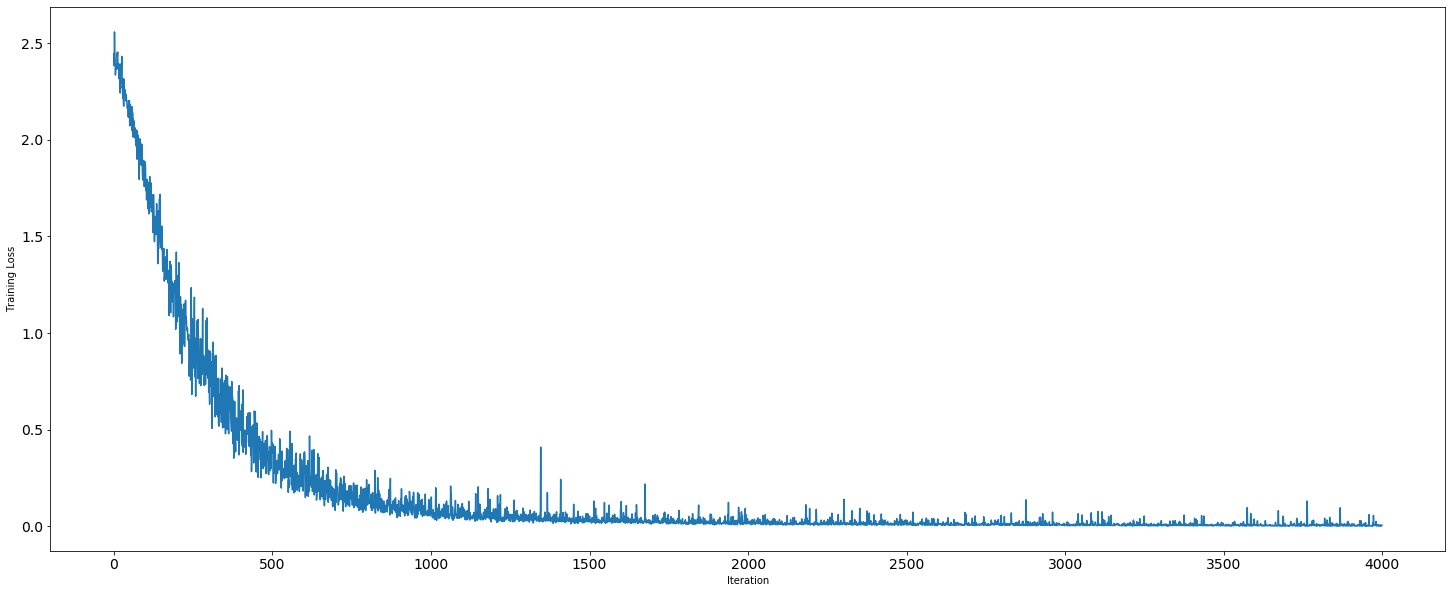

<Figure size 432x288 with 0 Axes>

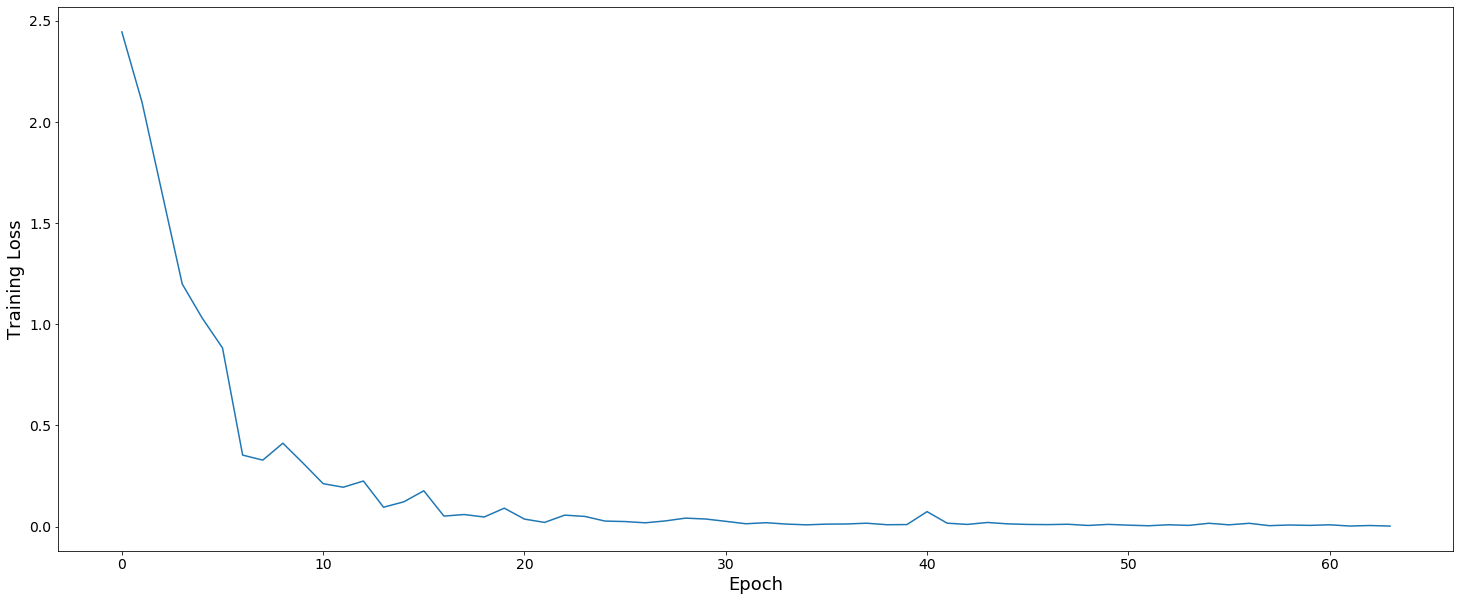

<Figure size 432x288 with 0 Axes>

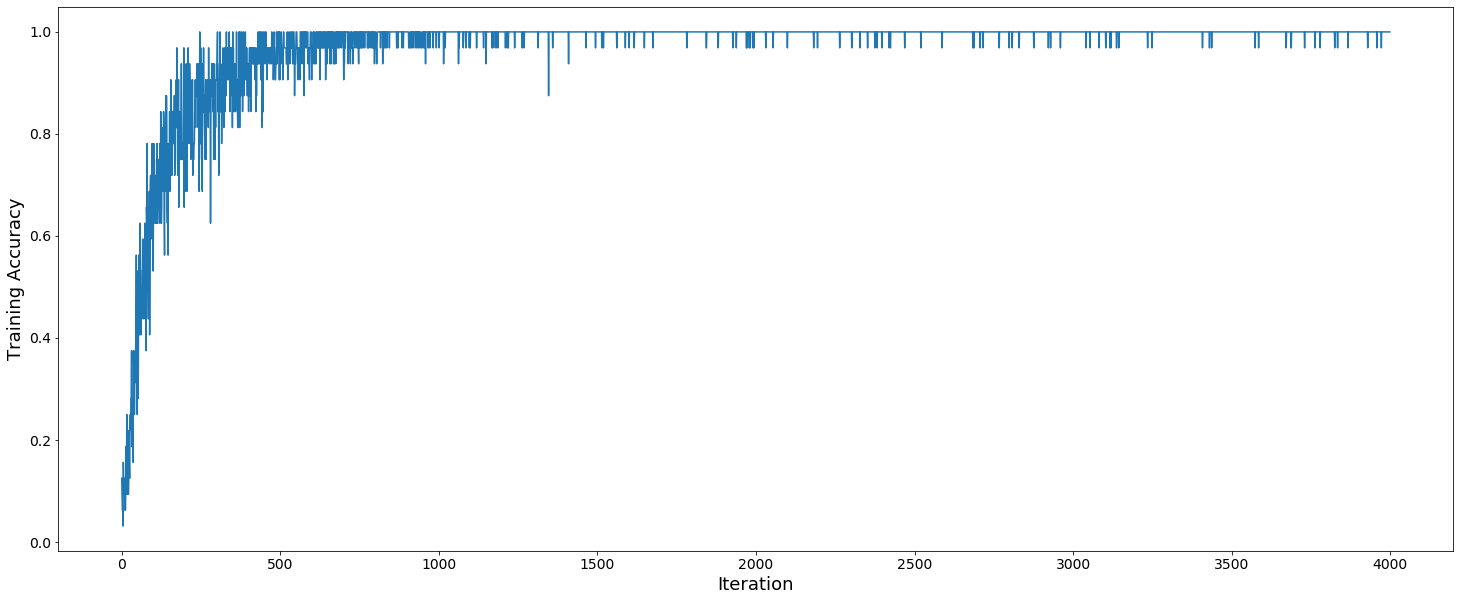

In [7]:
# Loss at the end of every Iteration

plt.figure(1)
plt.figure(figsize = (25,10))
plt.plot(np.array(loss_train_list), '-')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.rc('axes', labelsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


# Loss at the end of every epoch

LossPerEpoch = []
for x in range(0, len(loss_train_list) +1, len(train_loader)):
    LossPerEpoch.append(loss_train_list[x])
    
plt.figure(2)
plt.figure(figsize = (25,10))
plt.plot(np.array(LossPerEpoch), '-')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.rc('axes', labelsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

plt.figure(3)
plt.figure(figsize = (25,10))
plt.plot(np.array(train_accuracy_list), '-')
plt.xlabel('Iteration')
plt.ylabel('Training Accuracy')
plt.rc('axes', labelsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Saving model and loading it for later use

In [1]:
# print("Our Model: \n\n", classifier, '\n')
# print("The state dict keys: \n\n", classifier.state_dict().keys())

# classifier.module.state_dict() must be used when saving the model since
# DataParalle() method was used while training

In [10]:
# saving the model as a checkpoint file
torch.save(classifier.module.state_dict(), 'densenet161_40000Iterations.pth')

In [ ]:
from numpy import savetxt

loss_densenet = np.array(loss_train_list)
accuracy_densenet = np.array(train_accuracy_list)

savetxt('loss_densenet161.csv', loss_densenet, delimiter=',')
savetxt('accuracy_densenet161.csv', accuracy_densenet, delimiter=',')